no negative sampling  

NN_word = 200  
num_features = 3

(2019.6.3) use fit (not fit_generator)  
(2019.6.16) lr_scheduler  

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from feature_eng import lowcols

In [3]:
import os.path
import sys
import re
import itertools
import csv
import datetime
import pickle
import random
from collections import defaultdict, Counter
import gc

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import gensim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import gensim
from keras.preprocessing.sequence import skipgrams
import tensorflow as tf

In [4]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, cmap=cmap, **kwargs)
def scatter(x, y, color, **kwargs):
    plt.scatter(x, y, marker='.')

### create sample data

In [5]:
NN_word = 200
NN_sentence = 10000
NN_SEG = 7

In [6]:
product_list = [ee+1 for ee in range(NN_word)]
user_list = [ee+1 for ee in range(NN_sentence)]

In [7]:
a, _ = divmod(len(user_list), NN_SEG)
a
cls_user = [int(user_id / (a+1)) for user_id in range(1, 1+len(user_list))]

In [8]:
a, _ = divmod(len(product_list), NN_SEG)
print(a)

cls_prod = [int(prod_id / (a+1)) for prod_id in range(1, 1+len(product_list))]

28


In [9]:
random.seed(0)

X_list = []

for ii in range(len(user_list)):
    cls = cls_user[ii]
    product_group = np.array(product_list)[np.array(cls_prod) == cls]
    nword = random.randint(5, 20)
    prods = random.sample(product_group.tolist(), nword)
    irow = np.zeros((1,NN_word))
    irow[0,np.array(prods)-1] = 1
    X_list.append(irow)

X = np.concatenate(X_list)
print(X.shape)
X

(10000, 200)


array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [10]:
X_df = pd.DataFrame(X, dtype=int)
X_df.index = ['r'+ee.astype('str') for ee in (np.arange(X_df.shape[0])+1)]
X_df.columns = ['c'+ee.astype('str') for ee in np.arange(X_df.shape[1])+1]
print(X_df.shape)
X_df.head()

(10000, 200)


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c191,c192,c193,c194,c195,c196,c197,c198,c199,c200
r1,0,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
r2,0,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
r3,1,1,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
r4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
r5,0,0,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_df.values.shape

(10000, 200)

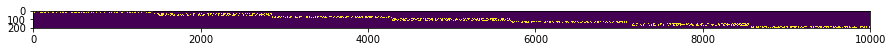

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(X_df.values.T)

In [13]:
wd2v = lowcols.WD2vec(X_df)
wd2v

In [14]:
num_features = 3

models = wd2v.make_model(num_user=X_df.shape[0], num_product=NN_word, num_features=num_features)
models['model_gk1'].summary()
models['model_user'].summary()
print('\n\n##################### model >>>')
model = models['model']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_user (InputLayer)      (None, 1)                 0         
_________________________________________________________________
user_embedding (Embedding)   (None, 1, 3)              30000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                 0         
_________________________________________________________________
gkernel1 (GaussianKernel3)   (None, 200)               601       
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_user (InputLayer)      (None, 1)                 0         
_________________________________________________________________
user_e

In [15]:
wd2v.models['model'].get_layer('user_embedding').get_weights()[0].shape

(10000, 3)

(10000, 3)


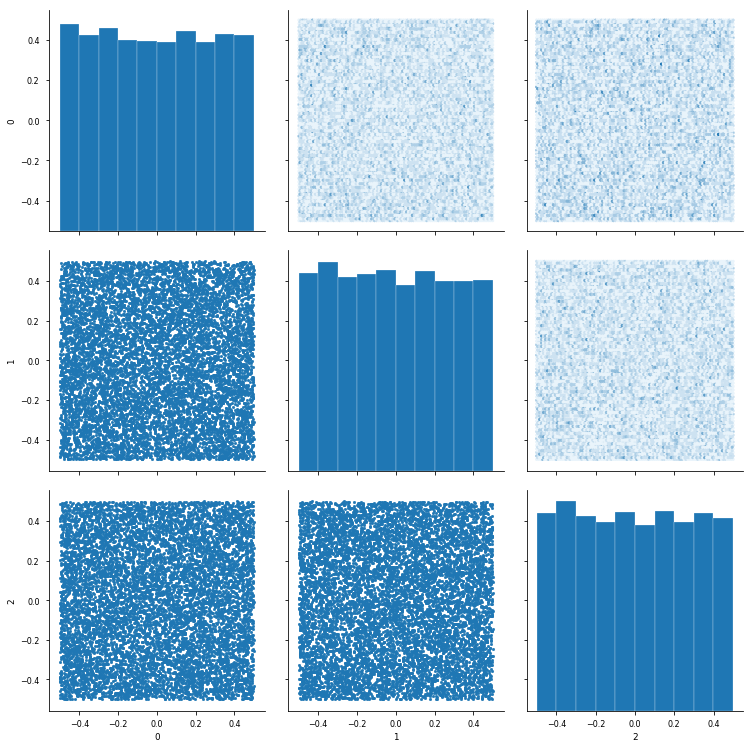

In [16]:
wgt_user = wd2v.get_wgt_byrow()
# wgt_user = model.get_layer('user_embedding').get_weights()[0]
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 3)


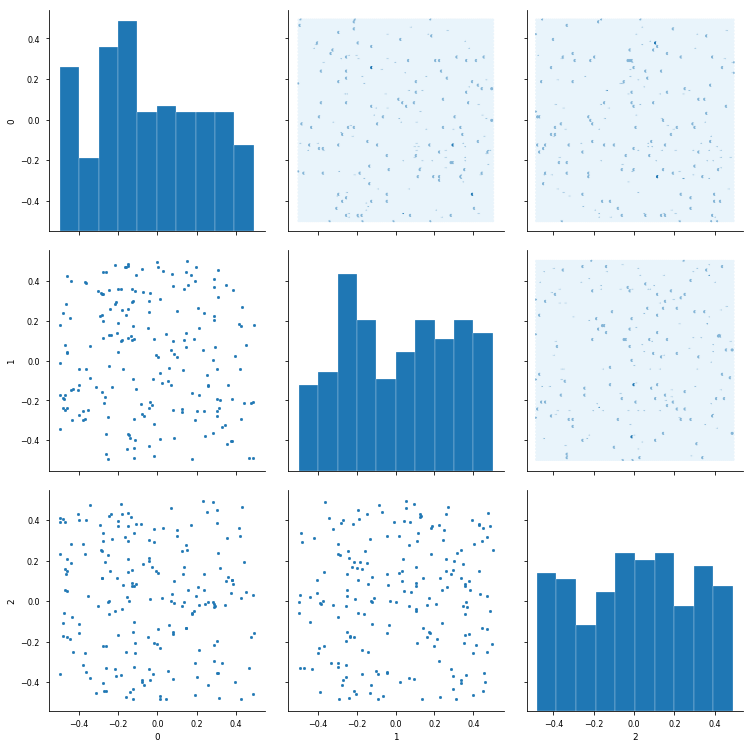

In [17]:
wgt_lm = wd2v.get_wgt_bycol()
print(wgt_lm.shape)
df = pd.DataFrame(wgt_lm[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

In [18]:
import keras
keras.__version__

'2.2.4'

### 1

In [19]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

def lr_schedule(epoch):
    def reduce(epoch, lr):
        if divmod(epoch,4)[1] == 3:
            lr *= (1/8)
        elif divmod(epoch,4)[1] == 2:
            lr *= (1/4)
        elif divmod(epoch,4)[1] == 1:
            lr *= (1/2)
        elif divmod(epoch,4)[1] == 0:
            pass
        return lr
    
    lr0 = 0.01
    epoch1 = 8
    epoch2 = 8
    epoch3 = 8
    epoch4 = 8
    
    if epoch<epoch1:
        lr = lr0
        #lr = reduce(epoch, lr)
    elif epoch<epoch1+epoch2:
        lr = lr0/2
        #lr = reduce(epoch, lr)
    elif epoch<epoch1+epoch2+epoch3:
        lr = lr0/4
        #lr = reduce(epoch, lr)
    elif epoch<epoch1+epoch2+epoch3+epoch4:
        lr = lr0/8
        #lr = reduce(epoch, lr)
    else:
        lr = lr0/16
    
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [lr_scheduler]

hst = wd2v.train(epochs=32, batch_size=32, verbose=2,
           callbacks=callbacks)

Epoch 1/32
Learning rate:  0.01
 - 2s - loss: 0.3295 - acc: 0.9045
Epoch 2/32
Learning rate:  0.01
 - 1s - loss: 0.2523 - acc: 0.9374
Epoch 3/32
Learning rate:  0.01
 - 1s - loss: 0.2360 - acc: 0.9377
Epoch 4/32
Learning rate:  0.01
 - 1s - loss: 0.2244 - acc: 0.9377
Epoch 5/32
Learning rate:  0.01
 - 1s - loss: 0.2061 - acc: 0.9377
Epoch 6/32
Learning rate:  0.01
 - 1s - loss: 0.1717 - acc: 0.9385
Epoch 7/32
Learning rate:  0.01
 - 1s - loss: 0.1255 - acc: 0.9425
Epoch 8/32
Learning rate:  0.01
 - 1s - loss: 0.1033 - acc: 0.9449
Epoch 9/32
Learning rate:  0.005
 - 1s - loss: 0.1021 - acc: 0.9449
Epoch 10/32
Learning rate:  0.005
 - 1s - loss: 0.0901 - acc: 0.9511
Epoch 11/32
Learning rate:  0.005
 - 1s - loss: 0.0877 - acc: 0.9522
Epoch 12/32
Learning rate:  0.005
 - 1s - loss: 0.0870 - acc: 0.9525
Epoch 13/32
Learning rate:  0.005
 - 1s - loss: 0.0870 - acc: 0.9524
Epoch 14/32
Learning rate:  0.005
 - 1s - loss: 0.0873 - acc: 0.9523
Epoch 15/32
Learning rate:  0.005
 - 1s - loss: 0.0

In [20]:
hst_history = hst.history

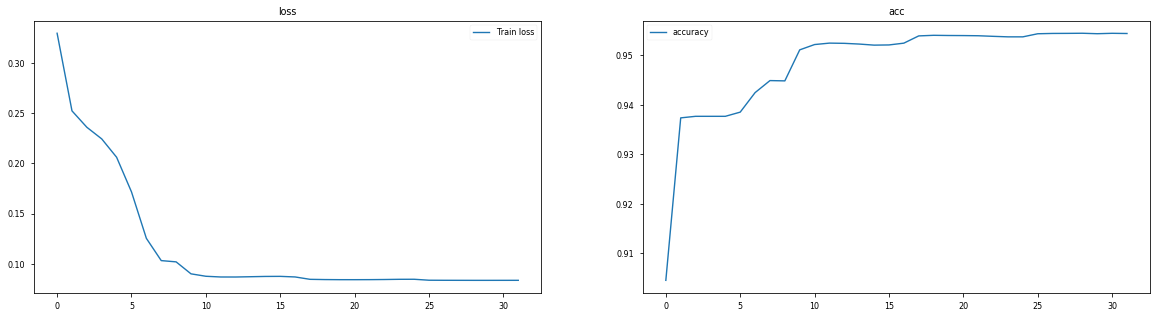

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst_history["loss"]))), hst_history["loss"], label="Train loss")
ax[1].set_title('acc')
ax[1].plot(list(range(len(hst_history["loss"]))), hst_history["acc"], label="accuracy")
ax[0].legend()
ax[1].legend()

(200, 3)


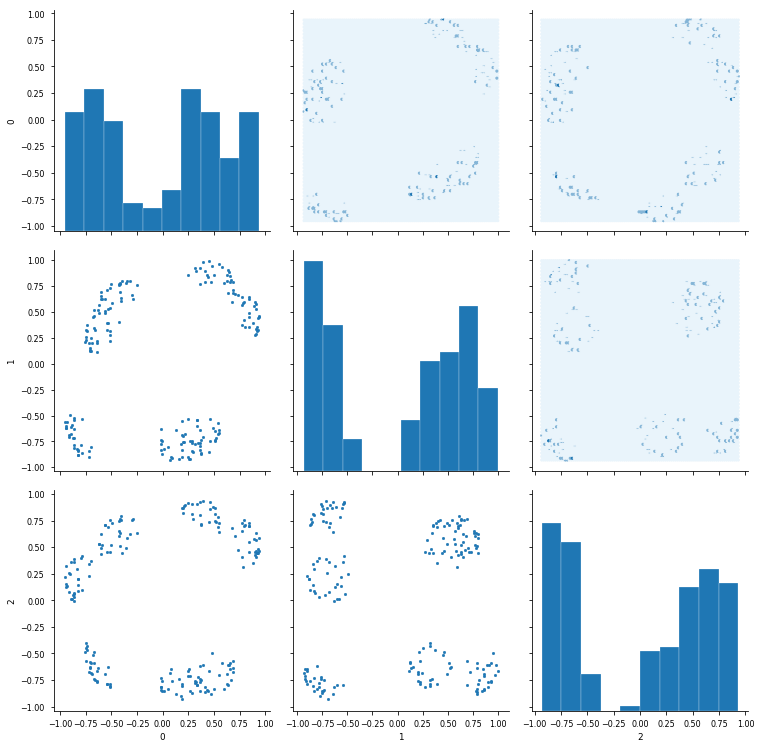

In [22]:
wgt_prod = wd2v.get_wgt_bycol()
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 3)


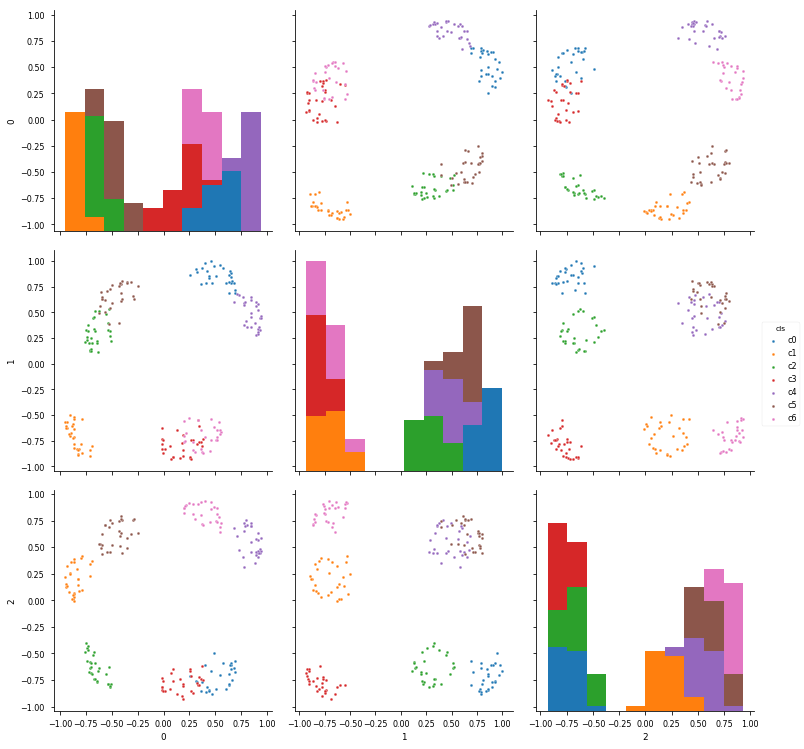

In [23]:
wgt_prod = wd2v.get_wgt_bycol()
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


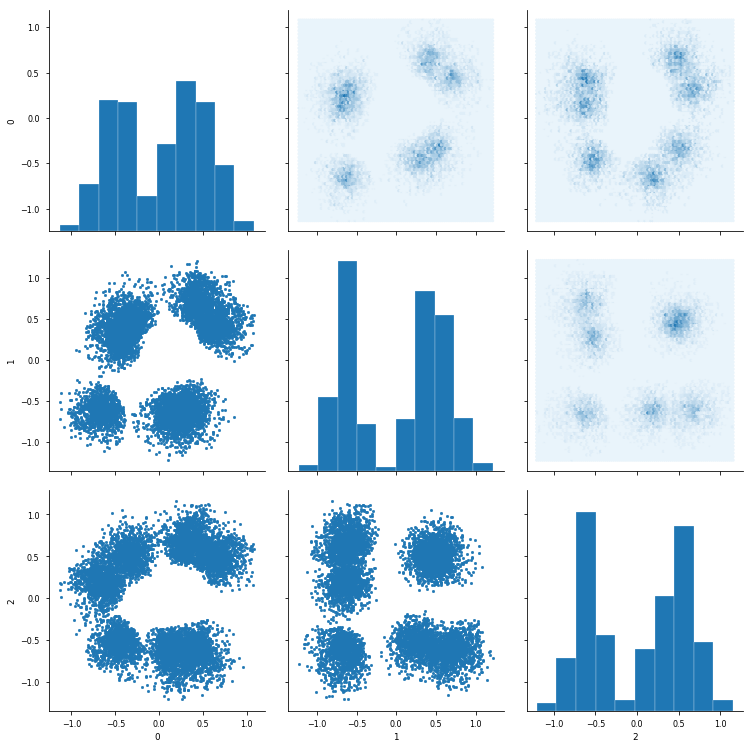

In [24]:
wgt_user = wd2v.get_wgt_byrow()
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 3)


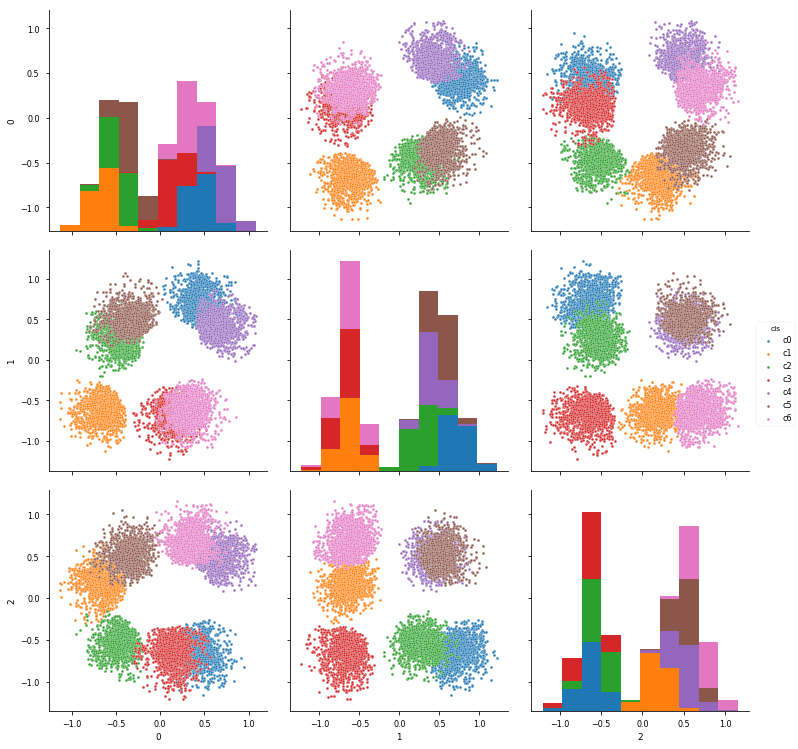

In [25]:
wgt_user = wd2v.get_wgt_byrow()
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

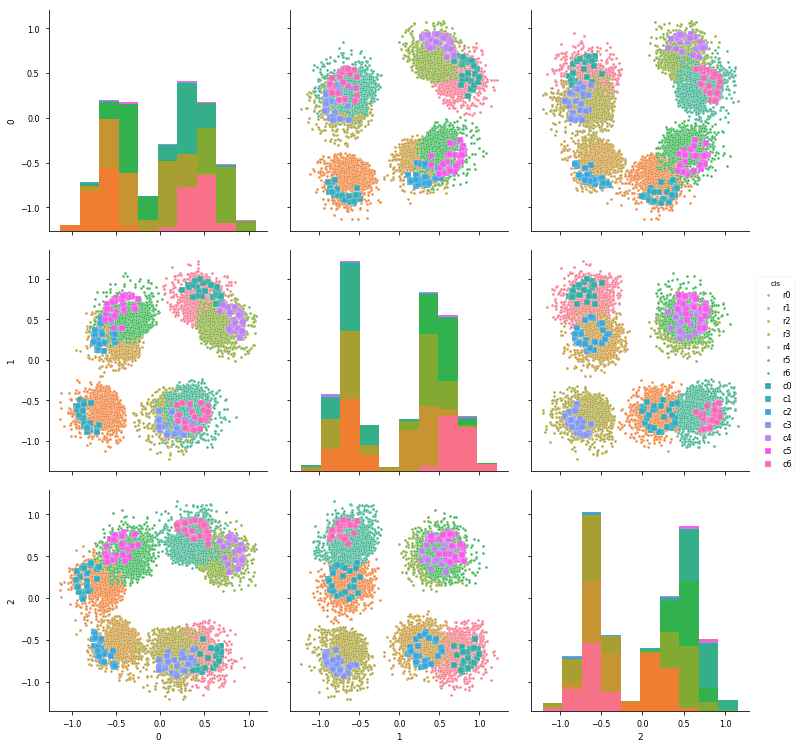

In [26]:
'''show row side and col side at the same time'''
df1 = pd.DataFrame(wgt_prod)
df1['cls'] = ['c'+str(ii) for ii in cls_prod]
df2 = pd.DataFrame(wgt_user)
df2['cls'] = ['r'+str(ii) for ii in cls_user]
df = pd.concat([df2, df1])
df.head()

sns.pairplot(df, markers=['.']*7+['s']*7, hue='cls', size=3.5, diag_kind='hist')

In [27]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [28]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(10200, 2)

In [29]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

,0,1,cls
0,1.195194,0.400424,c0
1,1.215645,0.370217,c0
2,1.180209,0.407802,c0
3,1.089390,0.185040,c0
4,1.183645,0.350922,c0


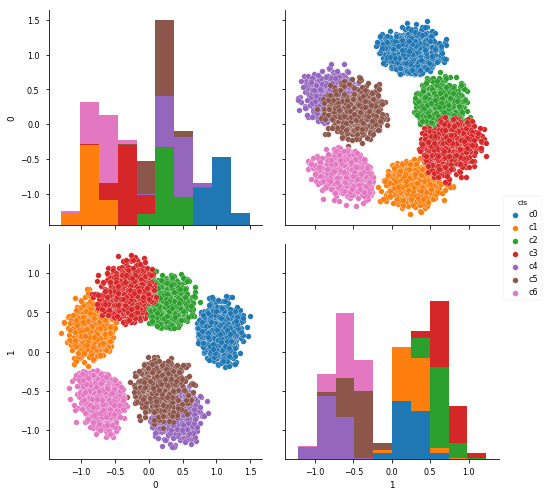

In [30]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [31]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(10200, 3)


In [32]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

,0,1,cls
0,81.990753,6.008040,c0
1,86.202255,-13.103298,c0
2,81.823845,6.162801,c0
3,73.501694,11.094989,c0
4,84.523407,-13.577013,c0


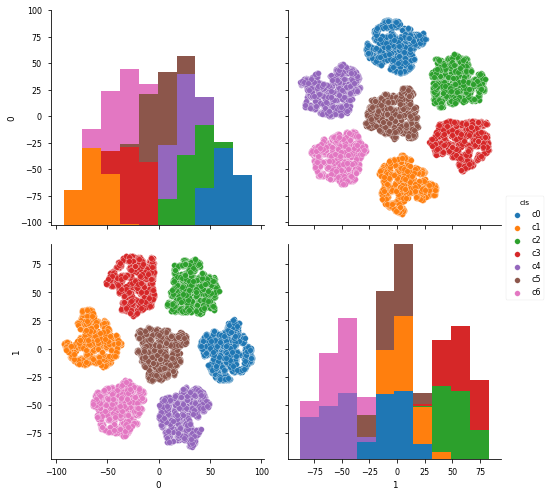

In [33]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')